#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
display(data.index.is_monotonic)

True

In [4]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [5]:
display(data.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
display(data.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполним ресемплирование по одному часу

In [7]:
data = data.resample('1H').sum() 

In [8]:
display(data.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные ресемплированы, расположены в хронологическом порядке.

**Вывод:**

В данном блоке были импортированы все необходимые библиотеки, загружен файл, который был преобразован в dataframe. 

В нашем распоряжении датасет, состоящий из 26496 строк и 2 столбцов: datetime — дата и время заказа такси; num_orders — количество заказов такси (целевой признак). Пропуски в данных отсутствуют.

Была проведена предобработка данных:

* переведен тип данных из object в datetime
* данные были проверены на монотонность
* произведен ресемплинг данных с диапазоном в 1 час

## Анализ

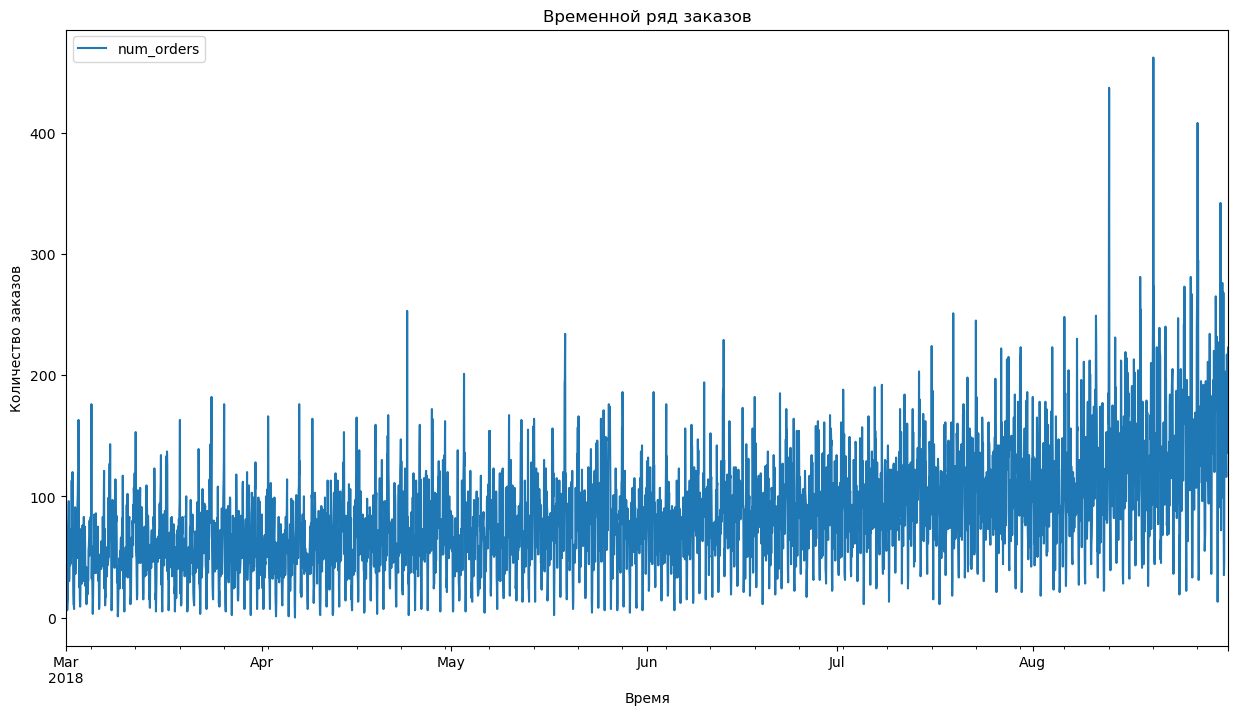

In [9]:
data.plot(figsize=(15,8), title = 'Временной ряд заказов')
plt.xlabel('Время')
plt.ylabel('Количество заказов');

Чтобы во временном ряду снизить колебания, применим скользящее среднее и стандартное отклонение.

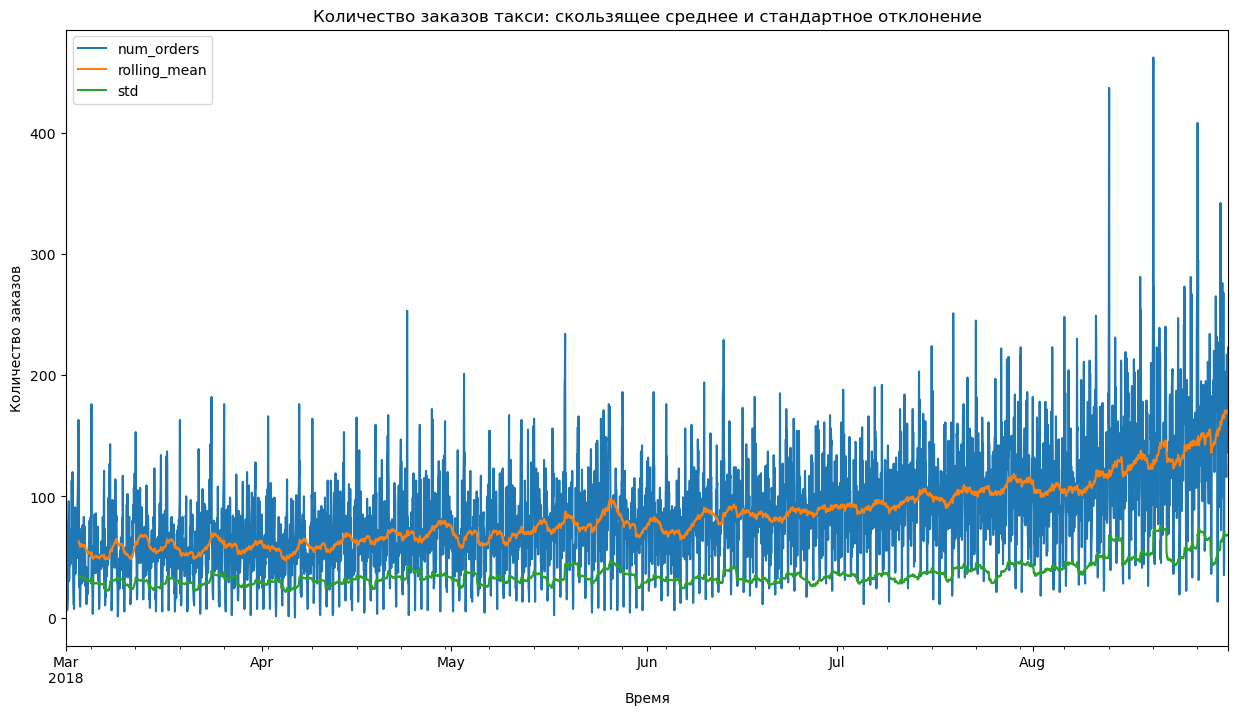

In [10]:
new_data = data.copy()
new_data['rolling_mean'] = new_data['num_orders'].rolling(50).mean()
new_data['std'] = new_data['num_orders'].rolling(50).std()
new_data.plot(figsize=(15,8), title='Количество заказов такси: скользящее среднее и стандартное отклонение')
plt.xlabel('Время')
plt.ylabel('Количество заказов');

Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу. Временной ряд нестационарный.

Вероятно, количество заказов увеличивается в летний период в связи с отпускным периодом. 

Чтобы лучше понимать временной ряд, разберём тренды и сезонность:

In [11]:
decomposed = seasonal_decompose(data)

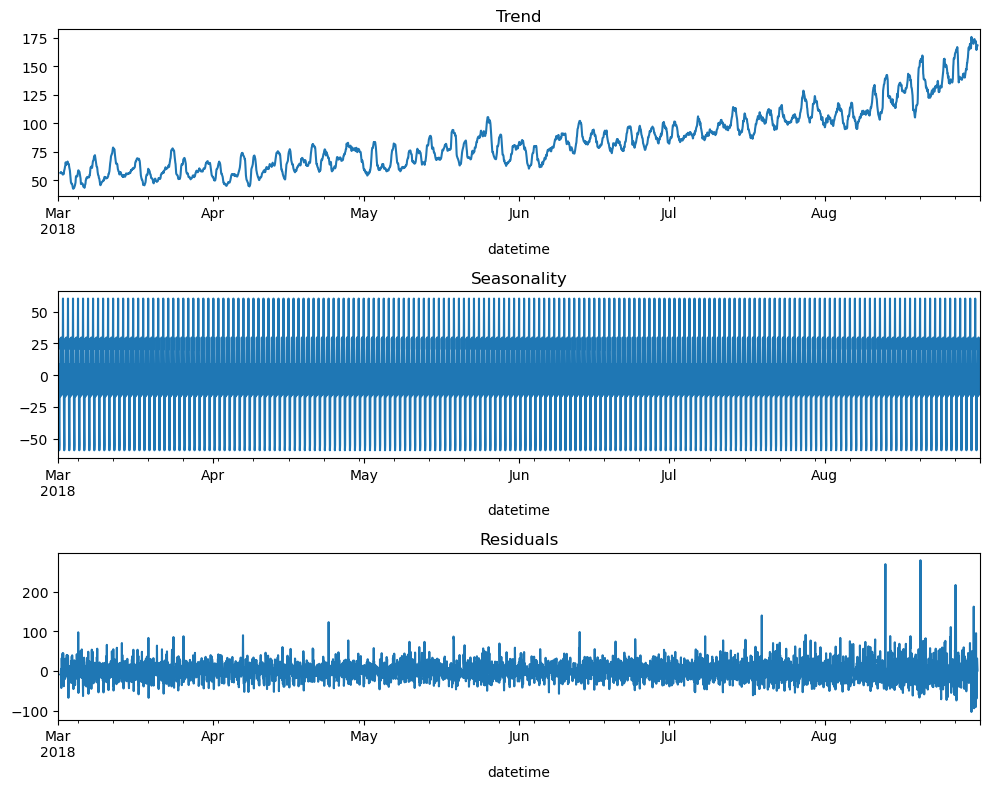

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим сезонность и высокую частотность. Посмотрим сезонную составляющую подробнее, уменьшив интервал:

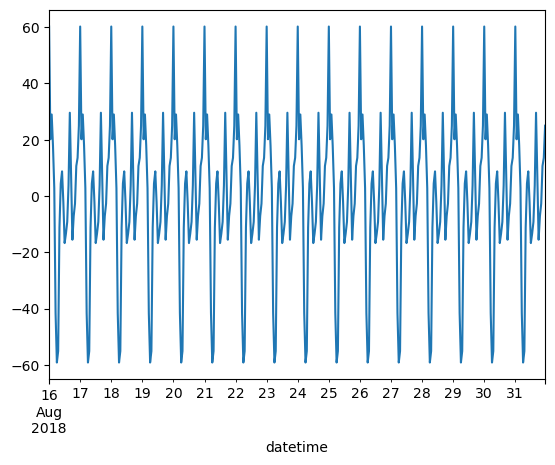

In [13]:
decomposed.seasonal['2018-08-16':'2018-08-31'].plot(); # последние 2 недели

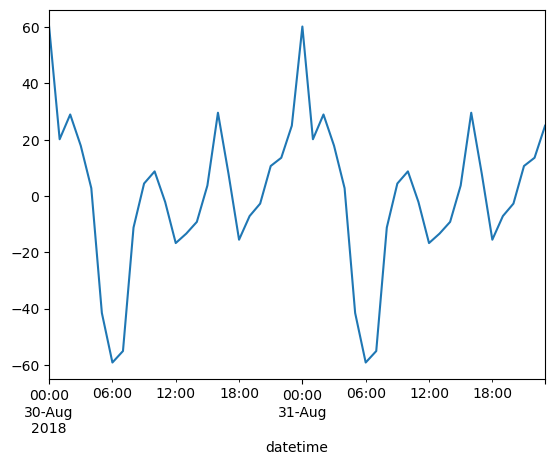

In [14]:
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(); # последние дни

Как видно из графиков, сезонность присутствует в течение дня. Реже всего такси заказывают в 6 утра, пик приходится на полночь. Так же такси часто заказывают около 17:00.

**Вывод:**
    
В данном блоке был проведен анализ данных. 

Методом декомпозиции мы пришли к следующим заключениям: 

* Наблюдается восходящий тренд количества заказов такси от месяца к месяцу за весь период наблюдения;
* Количество заказов увеличивается в летний период;
* Явно видна суточная сезонность: в 6 утра количество заказов стремится к нулю, в то время как полночь и вечерний час пик  - моменты самого сильного спроса на услуги такси.

Данные проанализированы и готовы к обучению.

## Обучение

Создадим признаки для горизонта прогнозирования в один шаг: календарные признаки, отстающие значения, скользящее среднее.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.fillna(0, inplace=True)
     
make_features(data, 20, 20)
print(data.head())

                     num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00         124      3    1          3    0.0    0.0    0.0   
2018-03-01 01:00:00          85      3    1          3  124.0    0.0    0.0   
2018-03-01 02:00:00          71      3    1          3   85.0  124.0    0.0   
2018-03-01 03:00:00          66      3    1          3   71.0   85.0  124.0   
2018-03-01 04:00:00          43      3    1          3   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_12  lag_13  lag_14  lag_15  \
datetime                                  ...                                   
2018-03-01 00:00:00    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0   
2018-03-01 01:00:00    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0   
2018-03-01 02:00:00    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0   
2018-03-01 03:00:00    0.0    0.0    0.0 

Разделим данные на выборки:

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(3974, 24)

(3974,)

(442, 24)

(442,)

Используем TimeSeriesSplits для кросс-валидации временных рядов

In [17]:
splits = TimeSeriesSplit(n_splits=3)

**RandomForestRegressor**

In [18]:
%%time

rf = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': list(range(100, 1000, 50)),
    'max_depth': list(range(1, 20, 5))
}
CV_rf = GridSearchCV(estimator=rf, param_grid=parameters, n_jobs=-1, verbose=3, cv=splits, scoring='neg_root_mean_squared_error')
CV_rf.fit(features_train, target_train)
CV_rf_best_par = CV_rf.best_params_
CV_rf_best_score = CV_rf.best_score_
print(CV_rf_best_par, 'RMSE=', CV_rf_best_score*(-1))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'max_depth': 16, 'n_estimators': 850} RMSE= 31.095881969461185
CPU times: user 29.2 s, sys: 579 ms, total: 29.8 s
Wall time: 4min 18s


**CatBoostRegressor**

In [19]:
%%time

cb = CatBoostRegressor(loss_function='RMSE')
parameters = {
    'depth': [5, 10, 20, 50, 100],
    'learning_rate': np.arange(0.01, 1, 0.2)
}
CV_cb = GridSearchCV(estimator=cb, param_grid=parameters, n_jobs=-1, verbose=2, cv=splits, scoring='neg_root_mean_squared_error')
CV_cb.fit(features_train, target_train)
CV_cb_best_par = CV_cb.best_params_
CV_cb_best_score = CV_cb.best_score_
print(CV_cb_best_par, 'RMSE=', CV_cb_best_score*(-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 2/3] END ...max_depth=1, n_estimators=200;, score=-35.053 total time=   0.6s
[CV 1/3] END ...max_depth=1, n_estimators=350;, score=-32.069 total time=   0.7s
[CV 2/3] END ...max_depth=1, n_estimators=450;, score=-34.988 total time=   1.2s
[CV 3/3] END ...max_depth=1, n_estimators=550;, score=-46.813 total time=   2.0s
[CV 2/3] END ...max_depth=1, n_estimators=750;, score=-34.974 total time=   2.1s
[CV 3/3] END ...max_depth=1, n_estimators=850;, score=-46.791 total time=   2.9s
[CV 1/3] END ...max_depth=6, n_estimators=200;, score=-29.684 total time=   1.2s
[CV 3/3] END ...max_depth=6, n_estimators=250;, score=-39.491 total time=   3.8s
[CV 1/3] END ...max_depth=6, n_estimators=450;, score=-29.757 total time=   2.7s
[CV 3/3] END ...max_depth=6, n_estimators=500;, score=-39.553 total time=   7.9s
[CV 2/3] END ...max_depth=6, n_estimators=700;, score=-30.439 total time=   7.5s
[CV 1/3] END ...max_depth=6, n_estimators=850;, 

**LGBMRegressor**

In [20]:
%%time

lgbm = LGBMRegressor() 
parameters = {
    'num_leaves':[20, 30, 50, 70, 100],
    'learning_rate': np.arange(0.01, 1, 0.2)
}
CV_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters, n_jobs=-1, verbose=2, cv=splits, scoring='neg_root_mean_squared_error')
CV_lgbm.fit(features_train, target_train)
CV_lgbm_best_par = CV_lgbm.best_params_
CV_lgbm_best_score = CV_lgbm.best_score_
print(CV_lgbm_best_par, 'RMSE=', CV_lgbm_best_score*(-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'learning_rate': 0.21000000000000002, 'num_leaves': 20} RMSE= 31.299272343171538
CPU times: user 1.62 s, sys: 623 ms, total: 2.24 s
Wall time: 12min 21s


Проверим все модели с наилучшими гиперпараметрами на тестовой выборке и выберем наилучшую.

## Тестирование

**RandomForestRegressor**

In [21]:
%%time

rf = RandomForestRegressor(random_state=12345, max_depth=16, n_estimators=850)
rf.fit(features_train, target_train)

CPU times: user 29 s, sys: 446 ms, total: 29.4 s
Wall time: 29.3 s


RandomForestRegressor(max_depth=16, n_estimators=850, random_state=12345)

In [22]:
%%time

rf_predictions = rf.predict(features_test)
print('RandomForest RMSE:', mean_squared_error(target_test, rf_predictions, squared=False))

RandomForest RMSE: 50.87698341325814
CPU times: user 90.2 ms, sys: 43.3 ms, total: 134 ms
Wall time: 187 ms


**CatBoostRegressor**

In [23]:
%%time

cb = CatBoostRegressor(loss_function='RMSE', depth=5, learning_rate=0.01)
cb.fit(features_train, target_train)

0:	learn: 38.5428003	total: 14.6ms	remaining: 14.6s
1:	learn: 38.4143518	total: 17.3ms	remaining: 8.65s
2:	learn: 38.2813033	total: 19.5ms	remaining: 6.47s
3:	learn: 38.1597858	total: 21.6ms	remaining: 5.38s
4:	learn: 38.0405823	total: 23.3ms	remaining: 4.64s
5:	learn: 37.9208669	total: 25.4ms	remaining: 4.2s
6:	learn: 37.8184503	total: 27.1ms	remaining: 3.84s
7:	learn: 37.7090546	total: 29.5ms	remaining: 3.66s
8:	learn: 37.5901829	total: 30.9ms	remaining: 3.4s
9:	learn: 37.4899122	total: 32.3ms	remaining: 3.19s
10:	learn: 37.3741916	total: 33.7ms	remaining: 3.03s
11:	learn: 37.2592967	total: 35.5ms	remaining: 2.93s
12:	learn: 37.1636093	total: 37.2ms	remaining: 2.83s
13:	learn: 37.0569751	total: 39ms	remaining: 2.75s
14:	learn: 36.9535243	total: 40.9ms	remaining: 2.68s
15:	learn: 36.8482455	total: 42.4ms	remaining: 2.6s
16:	learn: 36.7570583	total: 44ms	remaining: 2.55s
17:	learn: 36.6575860	total: 45.5ms	remaining: 2.48s
18:	learn: 36.5579306	total: 47ms	remaining: 2.43s
19:	learn: 3

In [24]:
%%time

cb_predictions = cb.predict(features_test)
print('CatBoost RMSE:', mean_squared_error(target_test, cb_predictions, squared=False))

CatBoost RMSE: 51.57205637964939
CPU times: user 2.72 ms, sys: 1.55 ms, total: 4.26 ms
Wall time: 6.21 ms


**LGBMRegressor**

In [25]:
%%time

lgbm = LGBMRegressor(num_leaves=20 , learning_rate=0.21)
lgbm.fit(features_train, target_train)

CPU times: user 577 ms, sys: 67.8 ms, total: 645 ms
Wall time: 99.1 ms


LGBMRegressor(learning_rate=0.21, num_leaves=20)

In [26]:
%%time

lgbm_predictions = lgbm.predict(features_test)
print('LGBMRegressor RMSE:', mean_squared_error(target_test, lgbm_predictions, squared=False))

LGBMRegressor RMSE: 47.58012337306765
CPU times: user 15.9 ms, sys: 5.85 ms, total: 21.7 ms
Wall time: 3.97 ms


**Вывод:**

Наилучшее значение метрики RMSE на тестовой выборке показала модель LGBMRegressor. RMSE = 47.58. Цель достигнута.

Посмотрим на графике предсказания лучшей модели LGBMRegressor в сравнении с правильными ответами:

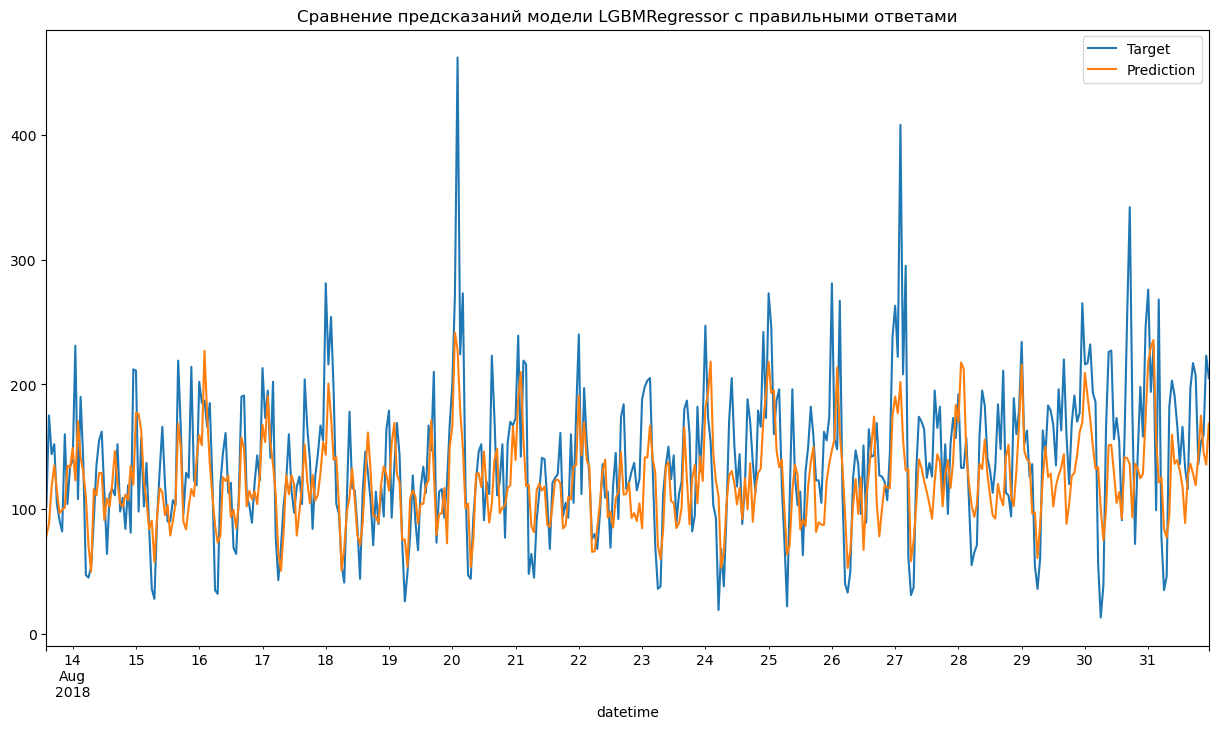

In [27]:
pd.DataFrame({'Target': target_test, 'Prediction': lgbm_predictions}).plot(figsize=(15,8), title='Сравнение предсказаний модели LGBMRegressor с правильными ответами');

**Вывод:**

В данном блоке были обучены три модели: RandomForestRegressor, CatBoostRegressor и LGBMRegressor.

Для кросс-валидации временных рядов был использован инструмент TimeSeriesSplits. Для подбора наилучших гиперпараметров использовался GridSearchCV. 

Наилучшее значение метрики RMSE на тестовой выборке показала модель LGBMRegressor. 

**Итоговый вывод:**

На первом этапе работы были загружены исторические данные о заказах такси в аэропортах. Данные были обработаны (в т.ч. произведен ресемплинг) и проанализированы.

На следующем этапе данные были подготовлены для обучения моделей: к датасету были добавлены дополнительные признаки (календарные признаки, отстающие значения, скользящее среднее), затем подобраны гиперпараметры для моделей. Модели были обучены с оптимальными гиперпараметрами. 

Далее было проведено финальное тестирование всех моделей, в ходе которого была выявлена модель с наилучшим показателем метрики качества RMSE. Модель-победитель - LGBMRegressor (RMSE=47.58). 

Цель работы достигнута - построена модель для предсказания количества заказов такси на следующий час. 